In [9]:
import sys
sys.path.append("../src/")
from data import train_and_testloader_from_pc, dataloader_from_pc
from model import AEDist
import numpy as np
import torch
import phate
from heatgeo.embedding import HeatGeo
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from scipy.spatial import procrustes
import scanpy as sc
import scprep
import matplotlib.pyplot as plt
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import wandb
import hydra
import os
from omegaconf import DictConfig, OmegaConf
import wandb
from hydra import initialize, compose
import pickle
import pandas as pd

In [2]:
data = np.load('../data/eb_hv_pca_subset.npy')
data_phate = np.load("../data/eb_hv_pca_subset_heatgeo.npy")

In [12]:
colors = pd.read_csv("../data/eb_hv_pca_subset_colors.csv", index_col=0)

In [3]:
run_name = 'run-20240109_134923-fsp0sxav'
cfg = OmegaConf.load(f'../src/wandb/{run_name}/files/config.yaml')

In [5]:
ckpt_path=f'../src/wandb/run-20240109_134923-fsp0sxav/files/epoch=13-step=33600.ckpt'
if cfg.model.value['activation'] == 'relu':
    activation_fn = torch.nn.ReLU()
elif cfg.model.value['activation'] == 'leaky_relu':
    activation_fn = torch.nn.LeakyReLU()
elif cfg.model.value['activation'] == 'sigmoid':
    activation_fn = torch.nn.Sigmoid()
else:
    raise ValueError('Unknown activation function')

model = AEDist.load_from_checkpoint(
    ckpt_path,
    dim=data.shape[1],
    emb_dim=data_phate.shape[1],
    layer_widths=cfg.model.value['layer_widths'],
    activation_fn=activation_fn,
    dist_reconstr_weights=cfg['model.dist_reconstr_weights'].value,
    log_dist=cfg.model.value['log_dist'],
    lr=cfg.model.value['lr'],
)


In [6]:
X_tensor = torch.from_numpy(data).float()
xhat, z = model(X_tensor)
xhat = xhat.cpu().detach().numpy()
z = z.cpu().detach().numpy()

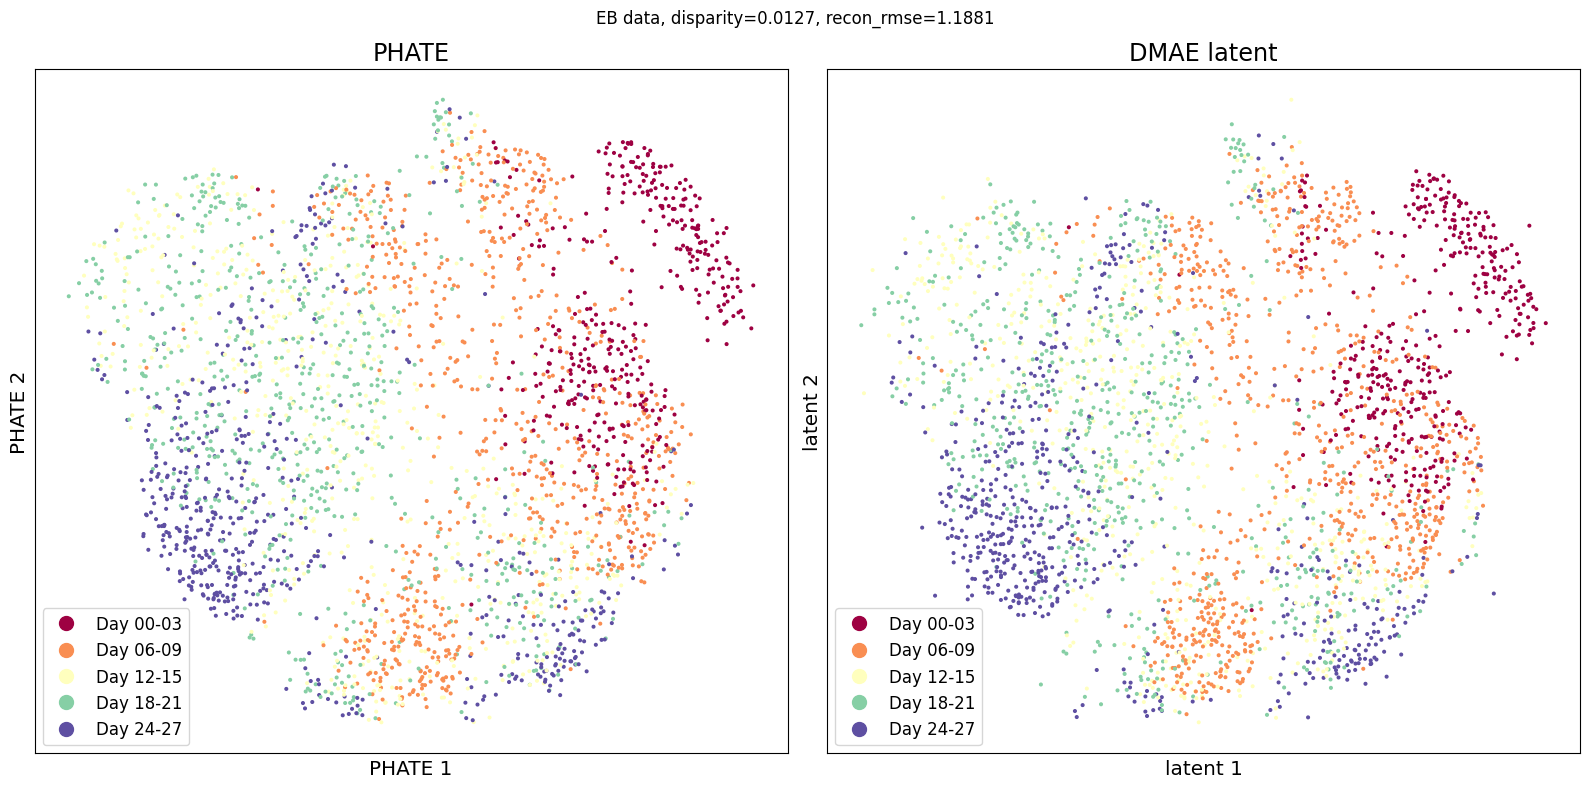

In [14]:
recon_rmse = np.sqrt(np.square(xhat - X_tensor.numpy()).mean())

pc_rot, z_rot, disparity = procrustes(data_phate, z)
# z_rot = procrustes.transform(z)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first scatter plot
scprep.plot.scatter2d(data_phate, ax=axes[0], c=colors, cmap='Spectral',
                      ticks=False, label_prefix="PHATE ", title='PHATE')

# Plot the second scatter plot
scprep.plot.scatter2d(z_rot, ax=axes[1], c=colors, cmap='Spectral',
                      ticks=False, label_prefix="latent ", title='DMAE latent')
plt.suptitle(f"EB data, disparity={disparity:.4f}, recon_rmse={recon_rmse:.4f}")
plt.tight_layout()
plt.show()